<a href="https://colab.research.google.com/github/Griffures/NLP-CatchUp/blob/master/catch_up_02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction to Natural Language Processing Catch-up 2


___
# Introduction

*(copied from subject)*

The second evaluation is made of a small project and theoritical questions on the course.

For coding standards, please respect the following guidelines

* Use docstring format to describe your functions and their arguments.
* Use typing.
* Have clear and verbatim variable names (not x, x1, x2, xx, another_x, ...).
* Make your results reproducible (force random seeds values when necessary and possible).

Don't hesitate commenting in details part of the code you consider complex or hard to read.


## Imports

Since we are using Colab for the GPU, no *conda.yml* nor *requirement.txt* will be given. To execute the code, please click on the "Open in Colab" button at the top of the file. 

In [26]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [27]:
# Pip install here. Sorry for log spam, didnt find a way to hide it in Colab.
!pip install datasets transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Testing the GPU

Next, we'll confirm that we can connect to the GPU with tensorflow:

In [28]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found : Out of quota !')
else:
  print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Forcing seed

This helps reproducibility, feel free to play with !

In [29]:
np.random.seed(42)

___
# Closing on the sentiment classifier 

## Library and dataset 

### Importing from HuggingFace

In [30]:
from datasets import load_dataset
ds_imdb_raw = load_dataset("imdb")

  0%|          | 0/3 [00:00<?, ?it/s]

### Train, test and validation split

In [31]:
# Using HF's train_test_split() function which does everything for us.
ds_imdb = ds_imdb_raw["train"].train_test_split(train_size=0.8,
                                                stratify_by_column="label",
                                                shuffle=True,
                                                seed=42)

# The func train_test_split() creates a split named 'test', we will rename it.
ds_imdb["validation"] = ds_imdb.pop("test")
ds_imdb["test"] = ds_imdb_raw["test"]

In [32]:
# Shuffling and printing DatasetDict's splits.
ds_imdb.shuffle(seed=42)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 25000
    })
})

Making sure it is stratified

In [33]:
# For each split in our DatasetDict
for split, ds in ds_imdb.items():
  # We get the class labels
  labels = ds.info.features['label'].names
  # We count the unique ones (count -> groupby)
  _, counts = np.unique(ds['label'], return_counts = True)
  # Then we concat all of that !
  print(f"In split {split} :", dict(zip(labels, counts)))

In split train : {'neg': 10000, 'pos': 10000}
In split validation : {'neg': 2500, 'pos': 2500}
In split test : {'neg': 12500, 'pos': 12500}


All good !

## Fine-tuning a model 

### Laying the gound works

In [34]:
from transformers import DistilBertTokenizer, DataCollatorWithPadding
from datasets import DatasetDict

# Tokenizer taken from loaded model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

def preprocess_function(records : DatasetDict) -> DatasetDict:
    return tokenizer(records["text"], truncation=True)

# Preprocessing our dataset
tokenized_imdb = ds_imdb.map(preprocess_function, batched=True)

# Creating DataCollector from tokenizer
# Not needed per Trainer's default arg using dynamic padding, but left for clarity.
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

loading file https://huggingface.co/distilbert-base-uncased/resolve/main/vocab.txt from cache at /root/.cache/huggingface/transformers/0e1bbfda7f63a99bb52e3915dcf10c3c92122b827d92eb2d34ce94ee79ba486c.d789d64ebfe299b0e416afc4a169632f903f693095b4629a7ea271d5a0cf2c99
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/added_tokens.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/special_tokens_map.json from cache at None
loading file https://huggingface.co/distilbert-base-uncased/resolve/main/tokenizer_config.json from cache at /root/.cache/huggingface/transformers/8c8624b8ac8aa99c60c912161f8332de003484428c47906d7ff7eb7f73eecdbb.20430bd8e10ef77a7d2977accefe796051e01bc2fc4aa146bc862997a1a15e79
loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf

  0%|          | 0/20 [00:00<?, ?ba/s]

  0%|          | 0/5 [00:00<?, ?ba/s]

  0%|          | 0/25 [00:00<?, ?ba/s]

In [35]:
# Our dataset now has two new features : input_ids and attention mask.
tokenized_imdb

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 20000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 5000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask'],
        num_rows: 25000
    })
})

In [36]:
from transformers import AutoModelForSequenceClassification

# Model used is "distilbert-base-uncased", as per recommended by the subject
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

loading configuration file https://huggingface.co/distilbert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/23454919702d26495337f3da04d1655c7ee010d5ec9d77bdb9e399e00302c0a1.91b885ab15d631bf9cee9dc9d25ece0afd932f2f5130eba28f2055b2220c0333
Model config DistilBertConfig {
  "_name_or_path": "distilbert-base-uncased",
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.20.1",
  "vocab_size": 30522
}

loading weights file https://huggingface.co/distilbert-base-uncased/resolve/main/pytorch_model.bin from cache at /root/.cache/huggingface/transformers/9c169103d7e5a

### Sample test run



In [37]:
from transformers import TrainingArguments, Trainer

# Training arguments : a single epoch
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=1,
)

# Simple trainer using our previous tokenizer.
# Data collator is not even needed here.
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [38]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20000
  Num Epochs = 1
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 2500


Step,Training Loss
500,0.393000
1000,0.317600
1500,0.293600
2000,0.253000
2500,0.263800


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1500
Configuration saved in ./results/checkpoint-1500/config.json
Model weights saved in ./results/checkpoint-1500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1500/special_toke

TrainOutput(global_step=2500, training_loss=0.30420628356933593, metrics={'train_runtime': 1010.5709, 'train_samples_per_second': 19.791, 'train_steps_per_second': 2.474, 'total_flos': 2503836675302592.0, 'train_loss': 0.30420628356933593, 'epoch': 1.0})

### Training workflow

In [39]:
from datasets import load_metric

# Metrics computing function that will be given to Trainer object
metric = load_metric("accuracy")

# Wrapping it, because Trainer objects return "logits"
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

In [40]:
# Using more precise parameters this time
# As well as an evaluation every epochs
training_args = TrainingArguments(
    output_dir="./results",
    num_train_epochs=5,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    weight_decay=0.01,
    evaluation_strategy="epoch"
)

# Same as before, just with different training args
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_imdb["train"],
    eval_dataset=tokenized_imdb["validation"],
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [41]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 20000
  Num Epochs = 5
  Instantaneous batch size per device = 16
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 1
  Total optimization steps = 6250


Epoch,Training Loss,Validation Loss,Accuracy
1,0.148300,0.214001,0.918200


Saving model checkpoint to ./results/checkpoint-500
Configuration saved in ./results/checkpoint-500/config.json
Model weights saved in ./results/checkpoint-500/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-500/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-500/special_tokens_map.json
Saving model checkpoint to ./results/checkpoint-1000
Configuration saved in ./results/checkpoint-1000/config.json
Model weights saved in ./results/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in ./results/checkpoint-1000/tokenizer_config.json
Special tokens file saved in ./results/checkpoint-1000/special_tokens_map.json
The following columns in the evaluation set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 5000
  Ba

KeyboardInterrupt: ignored

**I HAVE EXHAUSTED MY GPU QUOTA**

Please see below the actual results of the training before the cut-off.

**Accuracy on training dataset : ~0.92**

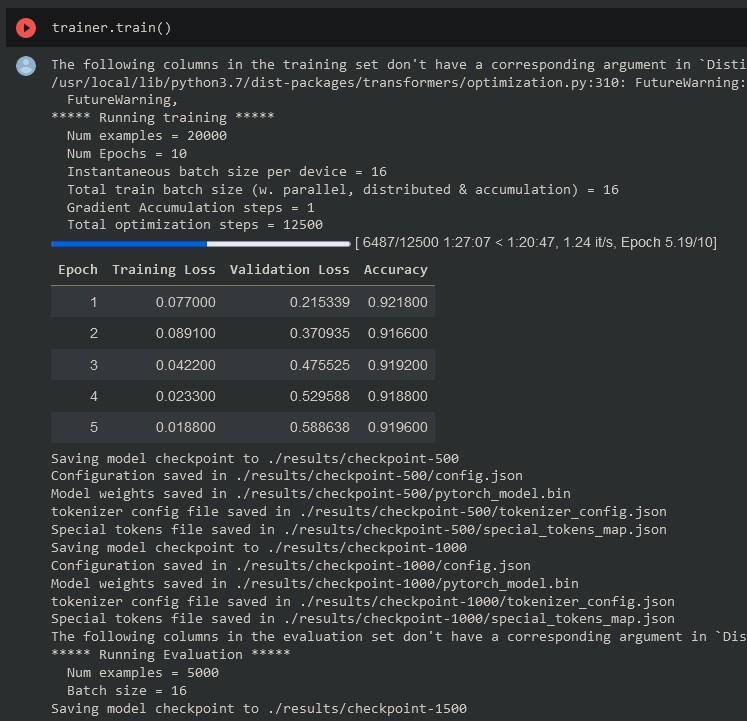

### Model evaluation

Accuracy on test data.

This is not really representative since it is a different model than the one used when I still had GPU ressources (had to cut off the dataset :-( )
-
**Accuracy should nonetheless appear here (as proven by previous screenshot)**

In [42]:
predictions, label_ids, metrics = trainer.predict(tokenized_imdb["test"])

The following columns in the test set don't have a corresponding argument in `DistilBertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `DistilBertForSequenceClassification.forward`,  you can safely ignore this message.
***** Running Prediction *****
  Num examples = 25000
  Batch size = 16


Epoch,Training Loss,Validation Loss,Accuracy
1,0.148300,0.214001,0.918200


In [83]:
metrics

{'test_accuracy': 0.9238,
 'test_loss': 0.32262319326400757,
 'test_runtime': 465.7433,
 'test_samples_per_second': 53.678,
 'test_steps_per_second': 3.356}

Accuracy on *test* split is **0.9238**

### Digging up errors

In [98]:
# Using Numpy mask to get all error documents
labels = tokenized_imdb["test"].info.features['label'].names
label_preds = np.argmax(predictions, axis=-1)
error_mask = np.array(label_preds != label_ids)

# Applying mak to dataset and predictions arrays
error_docs = np.array(tokenized_imdb["test"])[error_mask]
error_preds = label_preds[error_mask]

# Simple printing
for i, doc in enumerate(error_docs[:10]):
  print(f'===> {i+1} : Expected {labels[doc["label"]]} got {labels[error_preds[i]]}\n{doc["text"]}.\n')

===> 1 : Expected neg got pos
First off let me say, If you haven't enjoyed a Van Damme movie since bloodsport, you probably will not like this movie. Most of these movies may not have the best plots or best actors but I enjoy these kinds of movies for what they are. This movie is much better than any of the movies the other action guys (Segal and Dolph) have thought about putting out the past few years. Van Damme is good in the movie, the movie is only worth watching to Van Damme fans. It is not as good as Wake of Death (which i highly recommend to anyone of likes Van Damme) or In hell but, in my opinion it's worth watching. It has the same type of feel to it as Nowhere to Run. Good fun stuff!.

===> 2 : Expected neg got pos
Ben, (Rupert Grint), is a deeply unhappy adolescent, the son of his unhappily married parents. His father, (Nicholas Farrell), is a vicar and his mother, (Laura Linney), is ... well, let's just say she's a somewhat hypocritical soldier in Jesus' army. It's only whe

**Analysis**

To be honest with our model, I would point **Review #1** to be positive too. While the author downplays Van Damme movies, which he acknowledge as not being for everybody, he still liked it the movie nonetheless "*Good fun stuff!*".

When can consider another perspective though, maybe we didn't understand the fundamental question of the dataset : While the authors *appreciated* the movie, he does not *recommend* it. Therefore we fell into the same trap as our model : *not recommended*.

**Review #2** is on the dead center of mediocrity. Even the reviwever doesn't seems to be sure (i.e. a solid 5/10 : "*midly enjoyable*").

**Review #6 is more interesting** : it seems the model fell into the *sarcastic and snarky tone* used by the author. It seems the underlying text here has not been understood. (Mostly the prevalence of "*...*" should have been a clue).

### ***DistilBert* vs *NaiveBayes***

The *DistilBERT* model used here is empirically better than our previous *NaiveBayes*, accuracy wise.

Thanks to the mechanism of attention, it is also way better at understanding *context*, even on more complex, long-winded sentences (whereas the *NB* model simply used the presence of words to synthetize a result, meaning it was vulnerable to negations depending on the number of N-Gram used).

However, while *DistilBERT* is still lighter than classic *BERT* models, it *takes ages* to even just fine-tune to the IMDB dataset. We trained *from scratch* the *NaiveBayes* model a 20th of the time, and without GPU computing !

We still gained 10 point of accuracy (~0.8X to ~0.9X), but the discrepancy in ressources used, in term of plus-value gained, may not be worth the upgrade depending on the severity of the task at hands. 

### Fine tune with accuracy as evaluation

In [ ]:
# It seems we need to derive the Trainer class into our own in order to modify our loss function
# Running on CPU ate my time already, have to pass, sorry !

___
# Theorical questions
Answer the following questions.
___

**1. What is the purpose of subword tokenization used by transformer models?**
   * Part of the answer is in the first part of the course (lesson 2).
   * What is the effect on the vocabulary size?
   * How does it impact out-of-vocabulary words (words which are not in the training data, but appear in the test data, or production environment)?


**Subword tokenization** is used to split composite words without loosing as much information as stemming. For example, *skipping* will become *skip* + *#ing*, we are still getting back to the stem of the word, but keeping on its own the suffix *ing*, which indicates continuity.

**This will also reduce vocabulary size**. For example, the corpus *older oldest younger youngest* will be represented by the vocabulary *old* + *young* + *#er* + *#est*, reducing size on greater length corpus. Moreover, the vocabulary is sometimes firther encoded with the more frequent pairs (BPE for example), reducing the size even more.

**For OOV words**, it will still try to decomposite them, making the model more robust. Keeping the same example, if *finest* is not known inside the vocabulary, but *finer* and *oldest* are, it will still know the stem *fin* and the suffix *#est*, essentially getting back to the meaning of the word.
___

**2. What are the differences between an RNN and an LSTM?**
   * What problem is an LSTM trying to solve compared to a basic RNN?

**Long/Short Term Memory networks are a subsets of Recurrent Neural Network**, albeit more sophisticated ones.

Each unit of a RNN forwards its result to the next unit for the latter's computation, essentially propagating information down the sequence. However, doing so tends to dilute the information, making training a RNN on long sequences difficult.

LSTM uses *special units* and *gates* that allow the information to fast forward faster, making the training quicker and context travel further down the sequence.

___

**3. When building an encoder-decoder model using an RNN, what is the purpose of adding attention?**
   * What problem are we trying to solve?
   * How does attention solve the problem?

**The attention mechanism** allows the RNN to *focus* on a specific part of the input sequence.
During the encoding phase of RNNs, a single vector need to be used to represent the entire input sequence. However, doing so can cause an information loss during the compression.

To do so, it uses a NN to learn which hidden encoder states to favour. (The best example being the translation of "European Economic area" to "Zone Economique Europeenne", for which the attention score for each words is stronger for its oppposite in the preposition).

___

**4. In a transformer model what is the multihead attention used for?**
   * What the purpose of self-attention?
   * Why do we use muliple head instead of one?

**Self attention is used to symbolise relation between words**. For example in the sentence "The quick brown fox jumps over the lazy dog", self attention will run a scalar product on the sentence to link token between each others.

That way, *quick* and *brown* will be linked to *fox* (meaning they will have a greater attention score versus the rest of the sentence), so does *lazy* and *dog*. This behavior would be the same as conventional attention, however, it is better for long term relationship. This would be seen by the link for *jumps*, which would be linked to *fox*, *over*, and *dog*.

**We uses multiple head attention as this allows multiple Queries, Keys, and Values**. Usually done *h* times, this gives us that many projections for our sentence inside our embedding spaces (i.e. extracting multiple perspectives according to multiple *subspaces*).

___
**5. In a transformer, what is the purpose of positional embedding?**
   * What would be the problem if we didn't use it?

**Positionnal embedding places each words of the vocabulary into a many-dimensionnal euclidian space.**. Each axes of the space is therefore seen as a feature of our tokens. This means that words with closer meanings are also closer in the euclidian space (allowing for easier clusterisation, synonym search, etc).

Moreover, embedding spaces are created in such a way that mathematical computation also carries meaning. For example, if $v('token')$ represent the vector of said token into our embedding space, then we could have the following relation :

$v('king') - v('man') + v('woman') ~= v('queen')$.

___

**6. What is the purpose of having benchmarks to evalute models?**

Benchmarking models allows us to quantify *how good* a model is for a specific task, while being fed the same amount of information (*dataset*) than other ones. This is often done with the measure of *accuracy*.

However, it must be noted than benchmarking a model should also include the ressources allocated to its correct execution (both in *training* and *prediction* phases). A model can be slightly better than another, but if the former takes thrice the ressources, then it may not be worth it.

It is especially important to remember that our quest for accuracy is asymptotic, and our energy ressources and carbon footprint *needs* to be accounted for.

___


**7. In the BERT model, describe the two tasks used for pre-training (unsupervised) with a few sentences.**
   * **\[Bonus\]** Are they really unsupervised?

In order to gain acces to a greater corpus of data, transformer such as BERT have been scraping corpus such as the wikipedia.

**To train on such unlabbelled data, they used the masked attention head**. BERT will obscure part of the input sentence it is fed. Then, it will try to guess back the masked words, punishing itself depending on the distance between the guessed token and the real one inside the embedding spaces.

While such a traning workflow is used on **unlabelled data**, it is not really **unsupervised**, as the model still as a *correct* sentence as a reference. This kind of workflow would be more akin to *data-augmentation*.

___

**8. In a few sentences, explain how the triplet loss is used to train a bi-encoder model for semantic similarity?**
   * The simplest version of the triplet loss.

**Triplet loss is used to increase the *margin* between different classes.** Using a reference *anchor*, *positive* labels (same as the anchor) will be brought closer while *negative* labels (different from the anchor) will be pushed further.

Now if we put sentences into a many-dimensional euclidian space (embedding space), similar sentences with similar labels will be brought closer together, essentially clustering them depending on their similarities.
___

**9. What is the purpose of using an Approximate Nearest Neighbour method to speed up search?**
   * What does it reduce?

**Approximate Nearest Neighbour speeds up queries (information retrieval) by reducing the least interesting dimensions on which it operates**. Therefore, while it will not return the *absolute closest* point, it will more often then not return one just as good (within a given margin of error which we can tolerate).

This is especially important on highly dimensional spaces, which our embedding spaces tends to be.


> "I don't care if you are wrong by X%, now run as fast as you can with that."
___